## ➤  Scrape The Economist Magzine Nov 2021 PDF

In [1]:
import pdfplumber

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore")

In [3]:
with pdfplumber.open("The_Economist_-_11_27_2021.pdf") as pdf:
    sentences = []
    for i in range(0,87):
        page = pdf.pages[i]
        text = page.extract_text()
        sentences.append(text)

## ➤ Text Cleaning

In [4]:
sentences = ' '.join([sentence.replace('\n',' ').replace("\xa0",' ').replace('\xad',' ').replace(
                                "\x81",' ').replace(
                                "\x8d", ' ').replace(
                                "\x90",'').replace(
                                "\x8f",'').replace(
                                "  "," ").replace(
                                "  "," ").strip() for sentence in sentences])

In [5]:
sentences = [sentence.strip() for sentence in sentences.split(".")]

In [6]:
df = pd.DataFrame({"Text":sentences})

In [7]:
from textblob import Word
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")

import re

In [8]:
# lower texts
df['Text'] = df['Text'].apply(lambda x: \
        ' '.join(x.lower() for x in x.split()))

# Remove symbols
df['Text'] = df['Text'].str.replace('[^\w\s]', '')

# Lemmatize
df['Text'] = df['Text'].apply(lambda x: \
        ' '.join([Word(word).lemmatize() for word in x.split()]))

# Remove stop words
df['Text'] = df['Text'].apply(lambda x: ' '.join(x
        for x in x.split() if x not in stopword_list))

# Remove numbers and errors
df['Text'] = df['Text'].apply(lambda x: ' '.join(x
        for x in x.split() if (len(x)>2 and len(x)<20) and not any(chr.isdigit() for chr in x))) 

In [9]:
df.head()

,Text
0,new geopolitical troublemaker germany coalitio...
1,concrete used manmade material earth
2,used must rst cured
3,weve developed new curing method storing every...
4,making strong regular concrete day instead fas...


## ➤ Sentiment Analysis

In [10]:
# Add Sentiment column
df['Sentiment'] = df['Text'].apply(lambda x: \
        10 * np.round(TextBlob(x).sentiment[0],3))

In [11]:
sns.set(style="ticks",
    rc={
        "figure.figsize": [12, 7],
        "text.color": "white",
        "axes.labelcolor": "white",
        "axes.edgecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "axes.facecolor": "#5C0E10",
        "figure.facecolor": "#5C0E10"}
    )
import matplotlib.pyplot as plt

In [12]:
colors = np.array([(0.811, 0.913, 0.145)]*len(df["Sentiment"]))
colors[df["Sentiment"] >= 0] = (0.529, 0.870, 0.972)

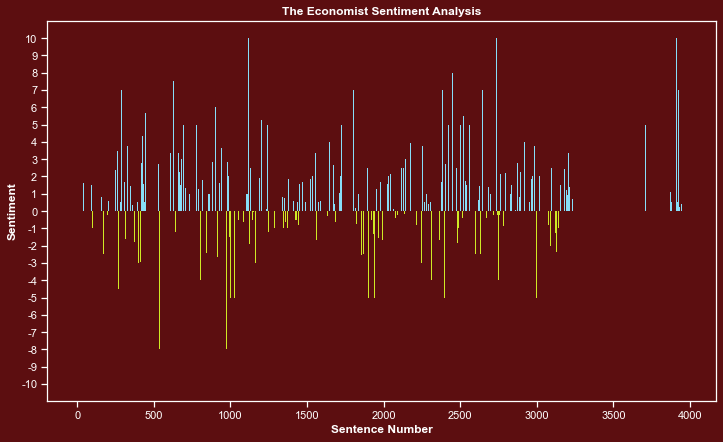

In [13]:
plt.bar(df.index, df["Sentiment"], color=colors, linewidth=0)
yticks_labels = [f"{np.round(i,0)}" for i in np.arange(-10, 11, 1)]
plt.yticks(np.arange(-10, 11, 1), yticks_labels)
plt.xlabel("Sentence Number", weight = "bold")
plt.ylabel("Sentiment", weight = "bold")
plt.title("The Economist Sentiment Analysis", fontweight="bold")
plt.show()

## ➤ Show Word Frequency

In [14]:
all_words = []

for t in df['Text']:
    for w in t.split(" "):
        all_words.append(w)

In [15]:
from collections import Counter

In [16]:
word_counts = Counter(all_words)
word_counts = sorted(word_counts.items(), key = lambda x:x[1], reverse = True)
word_counts = pd.Series(dict(word_counts))

In [17]:
top20word = word_counts[:20]
top20word

              526
year          184
say           171
one           149
new           132
america       106
would         106
country       103
also          101
time           94
government     91
november       90
state          84
many           84
may            83
china          82
people         79
could          77
rms            76
like           73
dtype: int64

In [18]:
from wordcloud import WordCloud
from PIL import Image

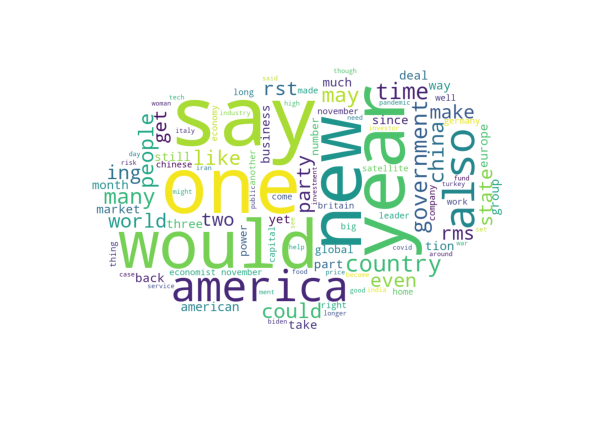

In [19]:
plt.style.use("seaborn-white")
wordcloud = WordCloud(mask = np.array(Image.open("cloud.png")), max_words = 100,
                          background_color = "white",
                          stopwords = stopwords.words('english'),
                      min_font_size = 8).generate(" ".join(all_words))

plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## ➤ Find Topics in The Economist November 2021

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [21]:
text_encoder = Pipeline([
    ('tfidf_vec', TfidfVectorizer(stop_words="english", min_df = 5, max_df = 0.9)),
    ('normalize', Normalizer()),
    ('lda', LDA(n_components = 15))], verbose=True)

In [22]:
tweet_vec = text_encoder.fit_transform(df['Text'])

[Pipeline] ......... (step 1 of 3) Processing tfidf_vec, total=   0.0s
[Pipeline] ......... (step 2 of 3) Processing normalize, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing lda, total=   2.3s


In [23]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [24]:
print_topics(text_encoder['lda'], text_encoder['tfidf_vec'], 10)


Topic #1:
country investor minister mean study chinese rms say prime hope

Topic #2:
italy bee rst half plane lockdown museum late caribbean say

Topic #3:
say turkey thing result executive project parent tions choose turkish

Topic #4:
like large year money say war business going start health

Topic #5:
sep used woman year wrong politics instead despite future time

Topic #6:
economist make november ing startup long rate latest com past

Topic #7:
men work item france section year democrat star telescope bjp

Topic #8:
list pakistan industry risk think little fund worth open economic

Topic #9:
new come congress matter russia company way largest available arbery

Topic #10:
gdp satellite launch year property main history india longer english

Topic #11:
source price better city tion century people diﬀ colombia global

Topic #12:
government day right good group iran state yemen saudi space

Topic #13:
china capital market president germany november change public united index

Topic #1